<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/adult_census/xgb_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip show xgboost scikit-learn

Name: xgboost
Version: 0.90
Summary: XGBoost Python Package
Home-page: https://github.com/dmlc/xgboost
Author: None
Author-email: None
License: Apache-2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: scipy, numpy
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, numpy, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, imbalanced-learn, fancyimpute


[国税調査データセット:https://www.openml.org/d/1590](https://www.openml.org/d/1590)

In [53]:
import cloudpickle, datetime, os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier, plot_tree

# データ読み込み

In [55]:
%%time
DATA_ID = '1590' #@param{type:'string'}

# データセットをフェッチ
result = fetch_openml(data_id=DATA_ID,
                    as_frame=True)
X = result.data
y = result.target
x_cols = result.feature_names
y_col = result.target_names

display(x_cols)
display(X.head())
display(y_col)
display(y.head())


def proc_y(y):
    '''ラベルの加工'''

    def _label_encode(y):
        '''ラベルエンコードしたnumpy.ndarrayを返す'''
        le = LabelEncoder()
        le.fit(y)
        return le.transform(y)

    proc_y = _label_encode(y=y)
    return proc_y


def proc_X(X, one_hot_encode_cols):
    '''特徴量の加工'''

    def _one_hot_encode(X, X_cols, drop_first=True):
        '''ワンホットエンコードしたDataframeを返す'''
        return pd.get_dummies(X, columns=X_cols,
                              drop_first=drop_first)

    proc_X = _one_hot_encode(X=X, X_cols=one_hot_encode_cols)
    return proc_X


one_hot_encode_cols = ['workclass', 'education', 'marital-status', 'occupation',
                       'relationship', 'race', 'sex', 'native-country']
X=proc_X(X=X, one_hot_encode_cols=one_hot_encode_cols)
y=proc_y(y=y)

display(X.head())
display(y)


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))



['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country']

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,NaN,103497.0,Some-college,10.0,Never-married,NaN,Own-child,White,Female,0.0,0.0,30.0,United-States


['class']

0    <=50K
1    <=50K
2     >50K
3     >50K
4    <=50K
Name: class, dtype: category
Categories (2, object): ['>50K', '<=50K']

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Self-emp-not-inc,workclass_Self-emp-inc,workclass_Federal-gov,workclass_Local-gov,workclass_State-gov,workclass_Without-pay,workclass_Never-worked,education_Some-college,education_11th,education_HS-grad,education_Prof-school,education_Assoc-acdm,education_Assoc-voc,education_9th,education_7th-8th,education_12th,education_Masters,education_1st-4th,education_10th,education_Doctorate,education_5th-6th,education_Preschool,marital-status_Divorced,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,marital-status_Married-spouse-absent,marital-status_Married-AF-spouse,occupation_Craft-repair,occupation_Other-service,occupation_Sales,occupation_Exec-managerial,occupation_Prof-specialty,occupation_Handlers-cleaners,...,native-country_Cambodia,native-country_England,native-country_Puerto-Rico,native-country_Canada,native-country_Germany,native-country_Outlying-US(Guam-USVI-etc),native-country_India,native-country_Japan,native-country_Greece,native-country_South,native-country_China,native-country_Cuba,native-country_Iran,native-country_Honduras,native-country_Philippines,native-country_Italy,native-country_Poland,native-country_Jamaica,native-country_Vietnam,native-country_Mexico,native-country_Portugal,native-country_Ireland,native-country_France,native-country_Dominican-Republic,native-country_Laos,native-country_Ecuador,native-country_Taiwan,native-country_Haiti,native-country_Columbia,native-country_Hungary,native-country_Guatemala,native-country_Nicaragua,native-country_Scotland,native-country_Thailand,native-country_Yugoslavia,native-country_El-Salvador,native-country_Trinadad&Tobago,native-country_Peru,native-country_Hong,native-country_Holand-Netherlands
0,25.0,226802.0,7.0,0.0,0.0,40.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,38.0,89814.0,9.0,0.0,0.0,50.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,28.0,336951.0,12.0,0.0,0.0,40.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44.0,160323.0,10.0,7688.0,0.0,40.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,18.0,103497.0,10.0,0.0,0.0,30.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


array([0, 0, 1, ..., 0, 0, 1])

'train shape:(31258, 97)'

'val shape:(7815, 97)'

'test shape:(9769, 97)'

CPU times: user 1.42 s, sys: 43.9 ms, total: 1.46 s
Wall time: 1.46 s


# モデル構築

In [56]:
N_JOBS = -1 #@param{type:'number'}
CV =  5#@param{type:'number'}
EARLY_STOP_ROUND = 2 #@param:{type:'number'}


classifier = XGBClassifier(n_jobs=N_JOBS, 
                           random_state=SEED)
display(classifier)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [57]:
%%time
classifier.fit(X=train_X, y=train_y,
               eval_set=[(val_X, val_y)],
               early_stopping_rounds=EARLY_STOP_ROUND,
               )

[0]	validation_0-error:0.157006
Will train until validation_0-error hasn't improved in 2 rounds.
[1]	validation_0-error:0.157006
[2]	validation_0-error:0.157006
Stopping. Best iteration:
[0]	validation_0-error:0.157006

CPU times: user 733 ms, sys: 31.5 ms, total: 764 ms
Wall time: 443 ms


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# モデルの評価

## XGBoostの組み込み評価関数

In [58]:
score = classifier.score(test_X, test_y)
display(score)

0.8349882280683796

### モデルの可視化

[0.00272619 0.         0.17241912 0.13885309 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.68600166 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]


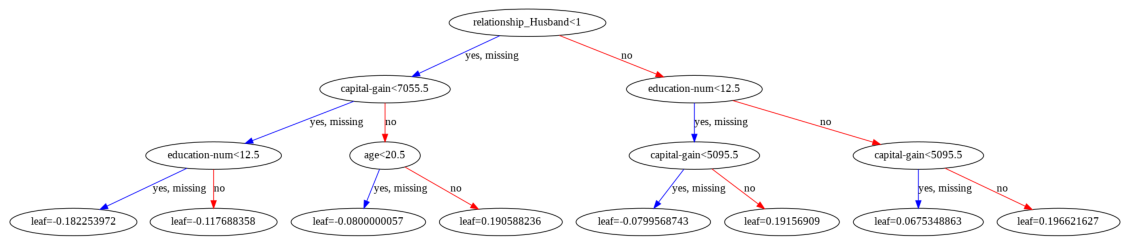

In [59]:
# 特徴量の重要度
print(classifier.feature_importances_)

# 木の可視化
_, ax = plt.subplots(figsize=(20, 20))
plot_tree(booster=classifier, ax=ax)

## sklearnの評価関数

In [60]:
# 予測結果の取得
train_y_pred = classifier.predict(train_X)
val_y_pred = classifier.predict(val_X)
test_y_pred = classifier.predict(test_X)

train_report = classification_report(y_true=train_y, y_pred=train_y_pred)
val_report = classification_report(y_true=val_y, y_pred=val_y_pred)
test_report = classification_report(y_true=test_y, y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)



              precision    recall  f1-score   support

           0       0.85      0.95      0.90     23781
           1       0.77      0.48      0.59      7477

    accuracy                           0.84     31258
   macro avg       0.81      0.72      0.74     31258
weighted avg       0.83      0.84      0.83     31258

----- -----
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      5915
           1       0.79      0.48      0.60      1900

    accuracy                           0.84      7815
   macro avg       0.82      0.72      0.75      7815
weighted avg       0.84      0.84      0.83      7815

----- -----
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      7459
           1       0.75      0.45      0.57      2310

    accuracy                           0.83      9769
   macro avg       0.80      0.70      0.73      9769
weighted avg       0.83      0.83      0.82      9